In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import xgboost as xgb
%matplotlib inline

In [6]:
# 读取数据
os.listdir("/Users/yanghao/github/data/customer_loss/")

['train_feature.csv', 'validate_feature.csv', 'predict_feature.csv']

In [134]:
path = "/Users/yanghao/github/data/customer_loss/"
train_data = pd.read_csv(path+'train_feature.csv')
validate_data = pd.read_csv(path+'validate_feature.csv')
pred_data = pd.read_csv(path+'predict_feature.csv')

/Users/yanghao/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


####  1. 预处理，包含缺失值填充   


In [135]:
def preprocess(data):
    char_cols = ['is_cre', 'cust_mrg', 'cust_sex', 'cust_regtyp', 
                 'is_staff_2', 'is_sy', 'is_gudong', 'is_bussma', "cust_crt_sct",
                 "gihhest_degree", "cust_occup_cod", 'old_obj_rating']
    d1 = {col:"str" for col in char_cols}
    data[char_cols] = data[char_cols].fillna('X')
    data = data.fillna(0)
    d2 = {col:'float' for col in ['licai_current', 'licai_future', 'licai_increasement']}
    d = dict(d1, **d2)
    
    data = data.astype(d)
    return data

####  2. 标签列的探索   ####


In [137]:
# 产生label，并且选取特征进行建模，其中需要进行one-hot
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)




def feature_engineer(data):
    # 需要留下哪些变量
    features = data.columns[16:]
    char_cols = ['is_cre', 'cust_mrg', 'cust_sex', 'cust_regtyp', 
                 'is_staff_2', 'is_sy', 'is_gudong', 'is_bussma', "cust_crt_sct",
                 "gihhest_degree", "cust_occup_cod", 'old_obj_rating']

    #data['label'] = data.apply(lambda x:x.net_loss > net_loss and (x.net_loss/x.bal_sum_current_all) > loss_ratio)
    data = data[features]
    data = data.drop('is_staff_1',axis=1)
    data = MultiColumnLabelEncoder(char_cols).fit_transform(data)
    return data
    
def get_label(data,net_loss,loss_ratio):
    data['label'] = data.apply(lambda x:x.net_loss > net_loss and (x.net_loss/x.bal_sum_current_all) > loss_ratio,axis=1)
    data['label'] = data['label'].astype('int')
    return data.label.values

#### 处理数据

In [138]:
y_train = get_label(train_data, 20000, 0.1)
X_train = feature_engineer(preprocess(train_data.drop('label',axis=1)))


y_validate = get_label(validate_data, 20000, 0.1)
X_validate = feature_engineer(preprocess(validate_data.drop('label',axis=1)))

X_pred = feature_engineer(preprocess(pred_data))

In [151]:
np.bincount(y_train)

array([20375,  3715])

In [168]:
20375/3715

5.484522207267833

In [188]:
# 进行xgboost训练
from xgboost import XGBClassifier
print(np.shape(X_train), np.shape(X_validate))

xg_model = XGBClassifier(n_estimators=500, learning_rate=0.2,
                         max_depth=5,booster='gbtree',
                        scale_pos_weight=5.5,reg_alpha=1,
                        min_child_weight=2,subsample=0.8)
xg_model.fit(X_train, y_train, early_stopping_rounds=50,
             eval_set=[(X_train, y_train),(X_validate, y_validate)], verbose=True,
             eval_metric='auc')

(24090, 170) (24186, 170)
[0]	validation_0-auc:0.853694	validation_1-auc:0.836539
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.859721	validation_1-auc:0.845507
[2]	validation_0-auc:0.866894	validation_1-auc:0.850003
[3]	validation_0-auc:0.870394	validation_1-auc:0.85336
[4]	validation_0-auc:0.872803	validation_1-auc:0.854557
[5]	validation_0-auc:0.874581	validation_1-auc:0.854984
[6]	validation_0-auc:0.876233	validation_1-auc:0.855723
[7]	validation_0-auc:0.877987	validation_1-auc:0.856837
[8]	validation_0-auc:0.880284	validation_1-auc:0.856133
[9]	validation_0-auc:0.882461	validation_1-auc:0.856837
[10]	validation_0-auc:0.883736	validation_1-auc:0.858056
[11]	validation_0-auc:0.886191	validation_1-auc:0.858454
[12]	validation_0-auc:0.887678	validation_1-auc:0.858208
[13]	validation_0-auc:0.889006	validation_1-auc:0.85851
[14]	validation_0-auc:0.890711	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=5.5, seed=None,
       silent=True, subsample=0.8)

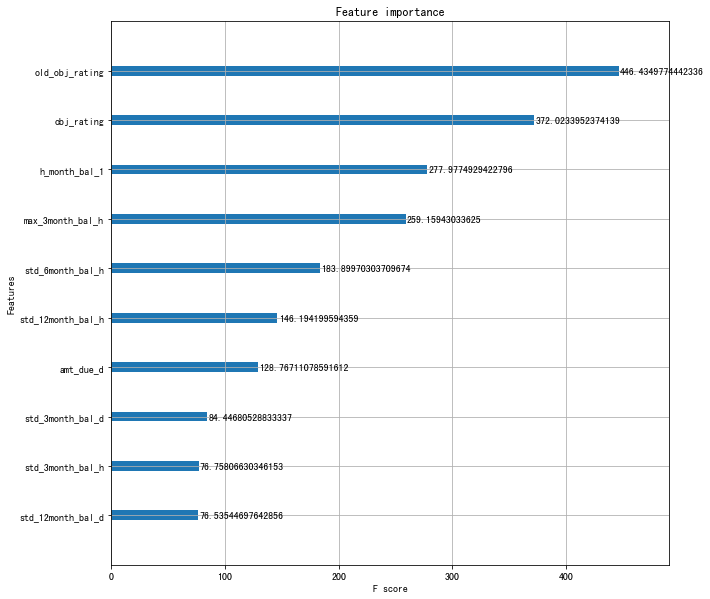

In [182]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(xg_model, max_num_features=10, ax=ax,
                   importance_type='gain')

In [187]:
# dart尝试
xg_dart = XGBClassifier(n_estimators=500, learning_rate=0.1,
                         max_depth=5,booster='dart',rate_drop=0.1,
                        scale_pos_weight=5.5,reg_alpha=1,
                        min_child_weight=2,subsample=0.8)
xg_dart.fit(X_train, y_train, early_stopping_rounds=50,
             eval_set=[(X_train, y_train),(X_validate, y_validate)], verbose=True,
             eval_metric='auc')

[0]	validation_0-auc:0.853694	validation_1-auc:0.836539
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.859637	validation_1-auc:0.848412
[2]	validation_0-auc:0.84758	validation_1-auc:0.848412
[3]	validation_0-auc:0.868658	validation_1-auc:0.853721
[4]	validation_0-auc:0.869549	validation_1-auc:0.855273
[5]	validation_0-auc:0.870761	validation_1-auc:0.85356
[6]	validation_0-auc:0.872067	validation_1-auc:0.855943
[7]	validation_0-auc:0.87237	validation_1-auc:0.85676
[8]	validation_0-auc:0.873719	validation_1-auc:0.856986
[9]	validation_0-auc:0.873435	validation_1-auc:0.856425
[10]	validation_0-auc:0.874878	validation_1-auc:0.856618
[11]	validation_0-auc:0.874704	validation_1-auc:0.857773
[12]	validation_0-auc:0.876312	validation_1-auc:0.85807
[13]	validation_0-auc:0.877297	validation_1-auc:0.858673
[14]	validation_0-auc:0.876089	validation_1-auc:0.859199
[15

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       rate_drop=0.1, reg_alpha=1, reg_lambda=1, scale_pos_weight=5.5,
       seed=None, silent=True, subsample=0.8)

### 代价敏感学习

+ resampling method
+ cost-sensitive algorithm
+ Cost-Sensitive Ensembles:Adacost